# SA v8: Sentiment Analysis 

The task for predicting if the text belong to either negative, neutral or positive sentiment, making this task a Multi-Class Classification task. Data dathered for this is performed both manually and programatically, which is reflected in the quality and quantity of the dataset. While labelling texts positive was relatively straight forward, properly distinguishing between negative and neutral at times seemed a bit tricky. A strong manual approach to gathering data has been performed in comparison to the other NLP tasks with which only around 4.5k data has been gathered. Nevertheless, the model is even able to learn from this few amount and results are enough for the prototype. 

## Notes
* trained on dataset 4.5k
* Made sure that the data is balanced (1.5k for each class)
* Would get better results with more quality data though


In [1]:
!pip install transformers==3.0.2 >> /dev/null
!pip install scikit-plot >>/dev/null

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn.functional as F
import scikitplot as skplt
from torch.nn import NLLLoss
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns;

# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')
import unicodedata
import time
import re
import gc

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
# Contants
PROJECT_PATH = '/content/drive/MyDrive/Colab/data/ma_data/'
DATA_GOLD = PROJECT_PATH + 'ma_feedback_sentiments_gold4k.csv'
MODEL_PATH = PROJECT_PATH + 'sa_model_gold4k_08'
RESULTS_PATH = PROJECT_PATH + 'sa_results_v8'

### Load Data

In [6]:
df_raw = pd.read_csv(DATA_GOLD, delimiter=";")
print(f"Data length: {len(df_raw)}")

Data length: 4567


In [7]:
df_raw.sample(5)

,id,feedback_text_en,sentiment,vader,vader score,delivery,feedback_return,product,monetary,one_hot_labels,normalized,normalized_with_stopwords,sent labels
3869,17924,"Everything was fine, as always",POSITIVE,NONE,0.2023,False,False,False,False,[0 0 0 0],everything fine always,everything be fine as always,POSITIVE
2345,3969,"Long returned, both at the same time with the ...",NEGATIVE,NONE,0.0000,False,True,False,False,[0 1 0 0],long returned time shoe receive confirmation s...,long return both at the same time with the sho...,NEUTRAL
3710,30250,"Was super fast and except for little things, w...",POSITIVE,POSITIVE,0.8402,False,False,False,False,[0 0 0 0],super fast except little thing meet expectatio...,be super fast and except for little thing whic...,POSITIVE
4411,22362,"good selection, great price, simple menu",POSITIVE,NONE,0.6249,False,False,True,True,[0 0 1 1],good selection great price simple menu,good selection great price simple menu,POSITIVE
1867,1788,"Ladies and Gentlemen In the returning e-mail, ...",NEGATIVE,NONE,0.1531,False,True,False,True,[0 1 0 1],return e mail item list returned purchase dedu...,and in the return e mail an item be not list t...,NEUTRAL


In [ ]:
def get_sentiment_values(sent_labels):
    def convert_to_value(label):
      if label == "NEGATIVE":
        return 0
      elif label == "NEUTRAL":
        return 1
      elif label == "POSITIVE":
        return 2
      else:
        return "ERROR"

    return list(map(convert_to_value, sent_labels))

In [ ]:
df_raw_labels = df_raw["sent labels"].tolist()
labels = get_sentiment_values(df_raw_labels)
df_copy = df_raw.copy()
df_copy["labels"] = labels

In [ ]:
texts = df_raw["feedback_text_en"].astype(str).tolist()
sentiments = df_copy["labels"].tolist()

The total number of data:  4567


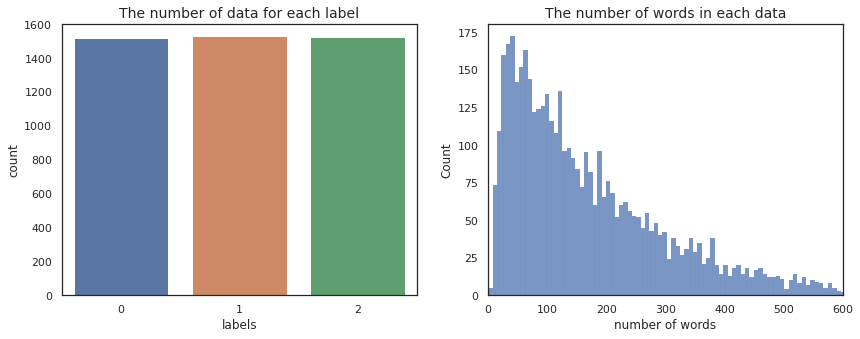

In [ ]:
print("The total number of data: ", len(df_copy))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))
sns.countplot(x='labels', data=df_copy, ax=ax1)
ax1.set_title('The number of data for each label', fontsize=14)

sns.histplot([len(x) for x in texts], ax=ax2, bins=1000)
ax2.set_title('The number of words in each data', fontsize=14)
ax2.set_xlim(0,600)
ax2.set_xlabel('number of words')
plt.show()

In [ ]:
train_df = { "text_raw": texts, "labels": sentiments }

# BERT

In [ ]:
def get_avg_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return acc, f1

In [ ]:
class DatasetPair(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return self.datalist[idx]

In [ ]:
def train_model(model, tokenizer, train_loader, valid_loader, epochs, patience, batch_size, seq_len, lr):
    num_training_steps = int(len(train_loader) * epochs)
    class_names = ['0:Negative','1:Neutral','2:Positive']
    print(f"class names: {class_names}")

    validate_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    print(f"\n===== Total Training Steps: {num_training_steps} = ({len(train_loader)} batches x {epochs} epochs) =====")

    # Setup training components
    optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warm_up_proportion,
                                                num_training_steps=num_training_steps)

    # Set to training mode
    model.train()

    # Initialize complete tracking variables
    acc_train, f1_train, loss_train, acc_valid, f1_valid, loss_valid = [], [], [], [], [], []
    best_f1, early_stop, steps = 0, 0, 0

    for epoch in tqdm(range(epochs), desc="Epoch"):
        print(f"\n===== Epoch: {epoch + 1} =====")

        # Initialize individual tracking variables
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []

        for batch in train_loader:
            text_batch, labels_batch = batch

            # Skip the last batch of which size is not equal to batch_size
            if labels_batch.size(0) != batch_size:
                break

            steps += 1
           
            # Reset gradient (default: gradients accumulate)
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % validate_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            text_encoded = tokenizer.batch_encode_plus(text_batch, 
                                                 max_length=seq_len, 
                                                 pad_to_max_length=True,
                                                 truncation=True,
                                                 return_tensors="pt").to(device)

            #labels = torch.tensor(labels_batch, dtype=torch.int64).to(device)
            labels = labels_batch.clone().detach().to(device)

            # Feedforward prediction for Multi-Class
            loss, logits = model(**text_encoded, labels=labels)

            y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()

            #################### Evaluation ####################
            if (steps % validate_every == 0) or ((steps % validate_every != 0) and (steps == len(train_loader))):

                # Evaluate Training
                acc, f1 = get_avg_metrics(y_truth_tmp, y_pred_tmp)
                acc_train.append(acc)
                f1_train.append(f1)
                loss_train.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                y_truth_tmp, y_pred_tmp = [], []

                # Evaluation Mode
                model.eval()

                for batch in valid_loader:
                    text_batch, labels_batch = batch

                    # Skip the last batch of which size is not equal to batch_size
                    if labels_batch.size(0) != batch_size:
                        break
            
                    text_encoded = tokenizer.batch_encode_plus(text_batch, 
                                                         max_length=seq_len, 
                                                         pad_to_max_length=True,
                                                         truncation=True,
                                                         return_tensors="pt").to(device)

                    labels = labels_batch.clone().detach().to(device)

                    # We do not need to update gradients during validation
                    with torch.no_grad():
                        loss, logits = model(**text_encoded, labels=labels)
                
                    loss_tmp += loss.item()
                    loss_cnt += 1

                    y_pred_tmp.extend(np.argmax(F.softmax(logits, dim=1).cpu().detach().numpy(), axis=1))
                    y_truth_tmp.extend(labels.cpu().numpy())

                acc, f1 = get_avg_metrics(y_truth_tmp, y_pred_tmp)
                print(f"Epoch: {epoch + 1}/{epochs}, Loss: {(loss_tmp / loss_cnt):.4f}, Acc: {acc:.4f}, F1: {f1:.4f}")
                acc_valid.append(acc)
                f1_valid.append(f1)
                loss_valid.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                # Back to train mode
                model.train()

        #################### End of each epoch ####################

        # Show the last evaluation metrics
        #print(f"\nEpoch: {epoch+1}, Loss: {loss_valid[-1]:.4f}, Acc: {acc_valid[-1]:.4f}, F1: {f1_valid[-1]:.4f}, LR: {scheduler.get_last_lr()[0]:.2e}\n")
        print(f"\nEpoch: {epoch+1}, Loss: {loss_valid[-1]:.4f}, Acc: {acc_valid[-1]:.4f}, F1: {f1_valid[-1]:.4f}, LR: {scheduler.get_last_lr()[0]:.2e}\n")
        
        # Plot Confusion Matrix
        true_classes = [class_names[int(idx)] for idx in y_truth_tmp]
        pred_classes = [class_names[int(idx)] for idx in y_pred_tmp]
        titles_options = [("Actual Count", None), ("Normalised", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(true_classes, pred_classes, normalize=normalize, title=title, x_tick_rotation="vertical")
        plt.show()

        # plot training performance
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.set_title("Losses")
        ax1.set_xlabel("Validation Cycle")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_train, 'b-o', label='Train Loss')
        ax1.plot(loss_valid, 'r-o', label='Valid Loss')
        ax1.legend(loc="upper right")
        
        ax2.set_title("Evaluation")
        ax2.set_xlabel("Validation Cycle")
        ax2.set_ylabel("Score")
        ax2.set_ylim(0,1)
        ax2.plot(acc_train, 'y-o', label='Accuracy (train)')
        ax2.plot(f1_train, 'y--', label='F1 Score (train)')
        ax2.plot(acc_valid, 'g-o', label='Accuracy (valid)')
        ax2.plot(f1_valid, 'g--', label='F1 Score (valid)')
        ax2.legend(loc="upper left")

        plt.show()

        # If improving, save the number. If not, count up for early stopping
        if best_f1 < f1_valid[-1]:
            early_stop = 0
            best_f1 = f1_valid[-1]
            torch.save(model.state_dict(), MODEL_PATH)
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Prepare for the next epoch
        torch.cuda.empty_cache()
        model.train()

    # Prepare for the next fold
    print(f"############## cleaning up ###############")
    del optimizer
    del scheduler
    gc.collect()
    torch.cuda.empty_cache()

    return loss_valid[-1], acc, f1, model

In [ ]:
def create_data_loaders_from_indices(X, y, train_indices, valid_indices, batch_size):

    # Instead of TensorDataset try encode during model training
    X_train = np.array(X)[train_indices].astype(str)
    y_train = np.array(y)[train_indices].astype(int)
    train_data = DatasetPair(X_train, y_train)

    X_valid = np.array(X)[valid_indices].astype(str)
    y_valid = np.array(y)[valid_indices].astype(int)
    validation_data = DatasetPair(X_valid, y_valid)

    # DataLoaders instead of conventional for loops to avoid memory issue during training
    train_sampler = RandomSampler(train_data) # Randomize train data because good practice
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    validation_sampler = SequentialSampler(validation_data) # Validation does not need to be randomized
    valid_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, valid_dataloader

In [ ]:
def train(n_splits, model_path, num_labels, X, y, epochs, patience, batch_size, seq_len, lr):
    print("\n############### Start training ###############")
    start_time = time.perf_counter() 
    loss_folds, acc_folds, f1_folds = [], [], []
    model_final = None

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for idx, (train_indices, valid_indices) in enumerate(kfold.split(X, y)):
        print(f"\n############### k-fold: {idx+1} ###############")

        # New model every fold
        model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)
        tokenizer = DistilBertTokenizer.from_pretrained(model_path, do_lower_case=True)
        model.to(device)

        train_dataloader, valid_dataloader = create_data_loaders_from_indices(X, 
                                                                              y, 
                                                                              train_indices, 
                                                                              valid_indices, 
                                                                              batch_size)


        loss, acc, f1, model_trained = train_model(model,
                                              tokenizer,
                                              train_dataloader, 
                                              valid_dataloader, 
                                              epochs, 
                                              patience, 
                                              batch_size, 
                                              seq_len, 
                                              lr)
        loss_folds.append(loss)
        acc_folds.append(acc)
        f1_folds.append(f1)

        # Save only the last model
        if idx == n_splits -1:
            model_final = model_trained

    end_time = time.perf_counter()
    duration = end_time - start_time
    print("Process Time (sec): {}".format(duration))
    print(f"acc: {acc:.4f}, f1: {f1:.4f}, duration: {duration / 1000}")

    return loss_folds, acc_folds, f1_folds, model_final

# Configure the model and train!¶


In [ ]:
NUM_FOLDS = 5 #@param {type:"number"}
MODEL_PATH = 'distilbert-base-uncased' #@param {type:"string"}
NUM_LABELS = 3 
EPOCHS = 3 #@param {type:"number"}
PATIENCE = 3 #@param {type:"number"}
BATCH_SIZE = 32 #@param {type:"number"}
SEQ_LEN = 180 #@param {type:"number"}
LR = 2e-5 #@param {type:"number"}


############### Start training ###############

############### k-fold: 1 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

class names: ['0:Negative', '1:Neutral', '2:Positive']

===== Total Training Steps: 345 = (115 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.4647, Acc: 0.8348, F1: 0.8347
Epoch: 1/3, Loss: 0.2777, Acc: 0.8996, F1: 0.9000
Epoch: 1/3, Loss: 0.2394, Acc: 0.9085, F1: 0.9091
Epoch: 1/3, Loss: 0.2118, Acc: 0.9208, F1: 0.9215

Epoch: 1, Loss: 0.2118, Acc: 0.9208, F1: 0.9215



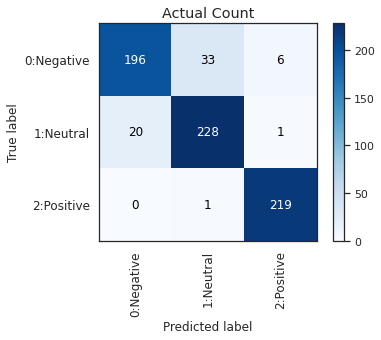

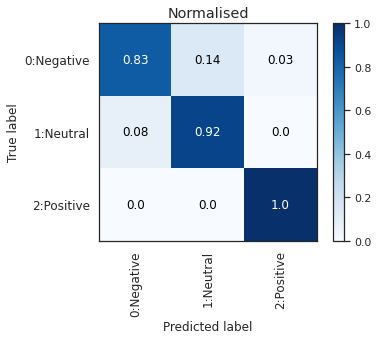

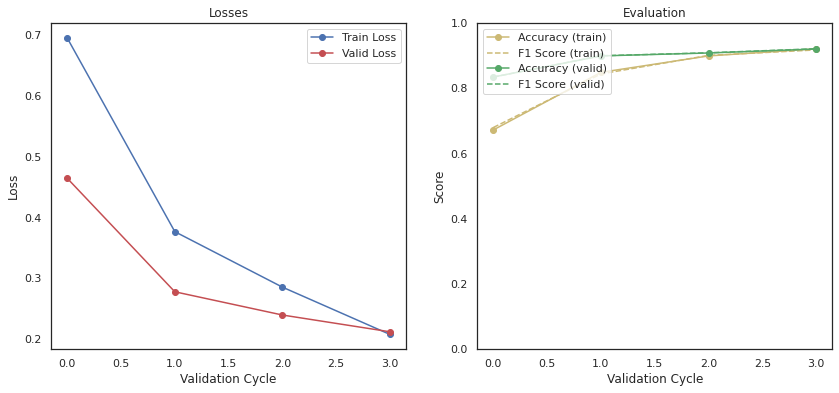

Epoch:  33%|███▎      | 1/3 [02:04<04:08, 124.30s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.2037, Acc: 0.9163, F1: 0.9166
Epoch: 2/3, Loss: 0.2096, Acc: 0.9185, F1: 0.9195
Epoch: 2/3, Loss: 0.1707, Acc: 0.9353, F1: 0.9360
Epoch: 2/3, Loss: 0.1580, Acc: 0.9375, F1: 0.9383
Epoch: 2/3, Loss: 0.2089, Acc: 0.9308, F1: 0.9319

Epoch: 2, Loss: 0.2089, Acc: 0.9308, F1: 0.9319



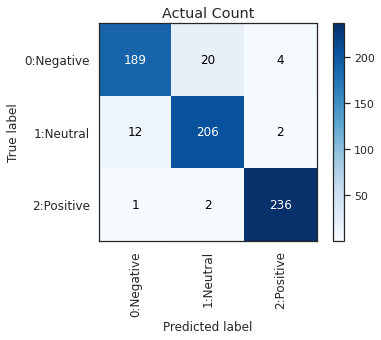

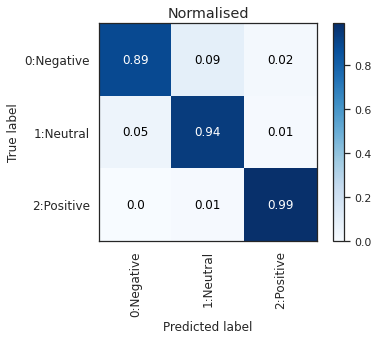

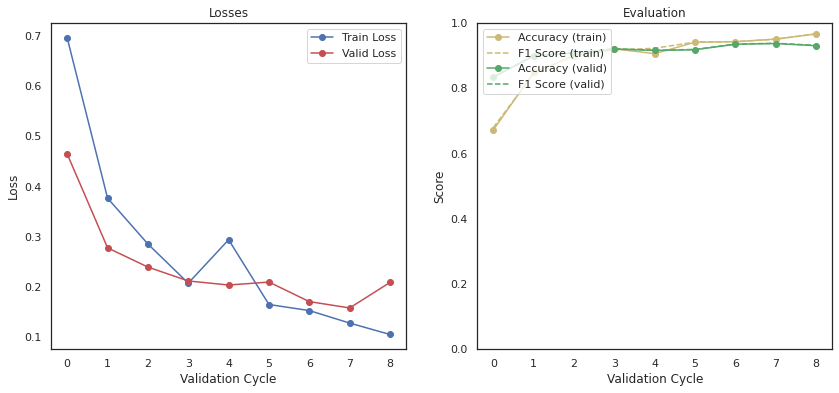

Epoch:  67%|██████▋   | 2/3 [04:20<02:07, 127.92s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.2150, Acc: 0.9118, F1: 0.9121
Epoch: 3/3, Loss: 0.1373, Acc: 0.9509, F1: 0.9515
Epoch: 3/3, Loss: 0.1489, Acc: 0.9498, F1: 0.9504
Epoch: 3/3, Loss: 0.1674, Acc: 0.9475, F1: 0.9482
Epoch: 3/3, Loss: 0.1482, Acc: 0.9531, F1: 0.9537

Epoch: 3, Loss: 0.1482, Acc: 0.9531, F1: 0.9537



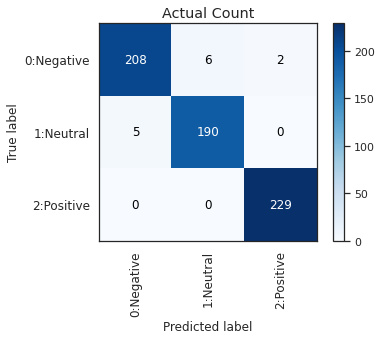

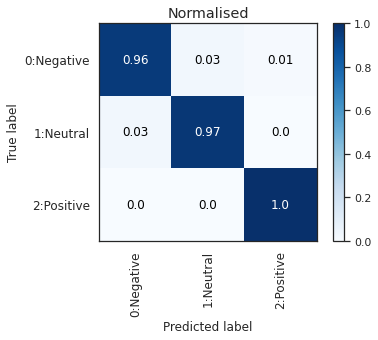

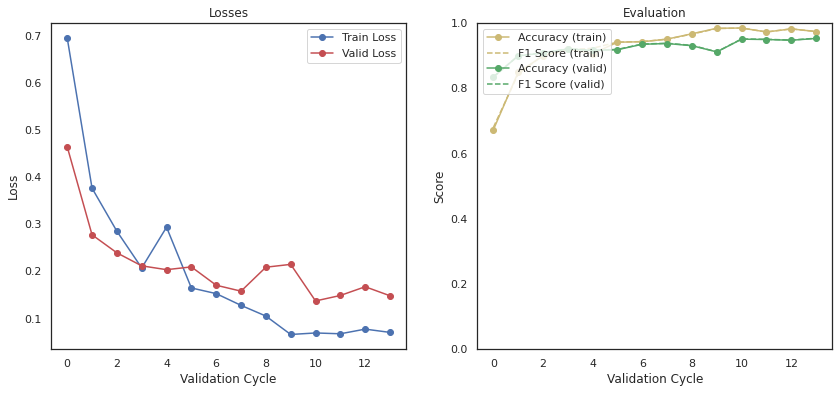

Epoch: 100%|██████████| 3/3 [06:37<00:00, 132.42s/it]


############## cleaning up ###############

############### k-fold: 2 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

class names: ['0:Negative', '1:Neutral', '2:Positive']

===== Total Training Steps: 345 = (115 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.4739, Acc: 0.7779, F1: 0.7648
Epoch: 1/3, Loss: 0.2708, Acc: 0.9007, F1: 0.9017
Epoch: 1/3, Loss: 0.2233, Acc: 0.9230, F1: 0.9229
Epoch: 1/3, Loss: 0.2550, Acc: 0.8917, F1: 0.8916

Epoch: 1, Loss: 0.2550, Acc: 0.8917, F1: 0.8916



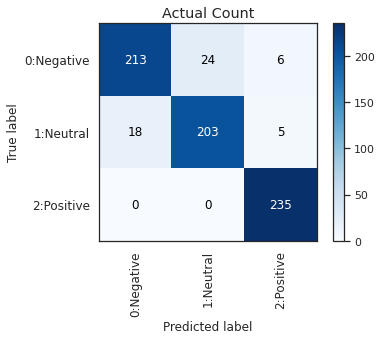

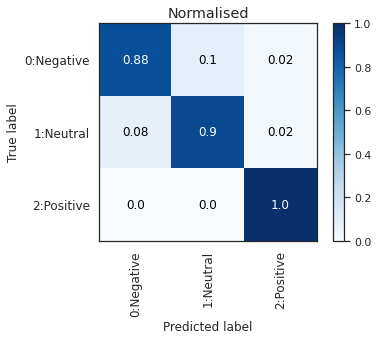

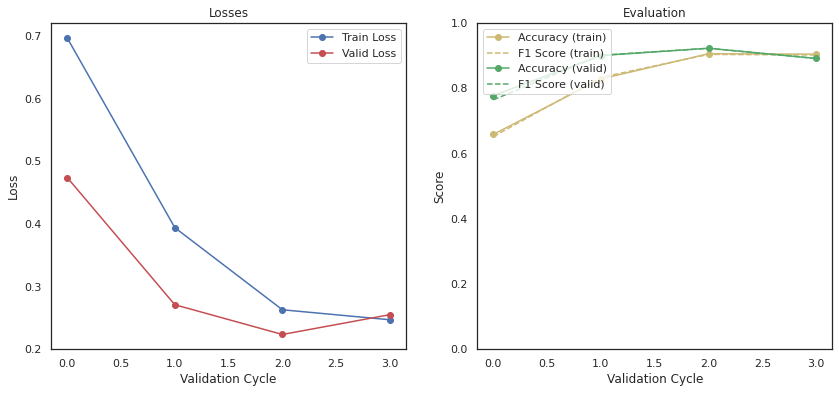

Epoch:  33%|███▎      | 1/3 [02:07<04:14, 127.26s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.1840, Acc: 0.9196, F1: 0.9206
Epoch: 2/3, Loss: 0.1907, Acc: 0.9330, F1: 0.9337
Epoch: 2/3, Loss: 0.1775, Acc: 0.9375, F1: 0.9382
Epoch: 2/3, Loss: 0.2144, Acc: 0.9286, F1: 0.9294
Epoch: 2/3, Loss: 0.1843, Acc: 0.9386, F1: 0.9393

Epoch: 2, Loss: 0.1843, Acc: 0.9386, F1: 0.9393



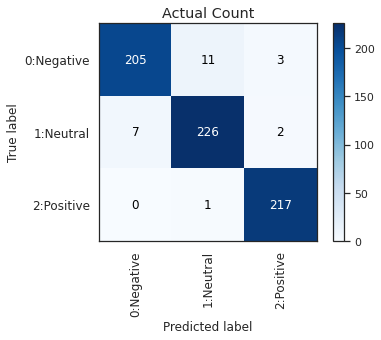

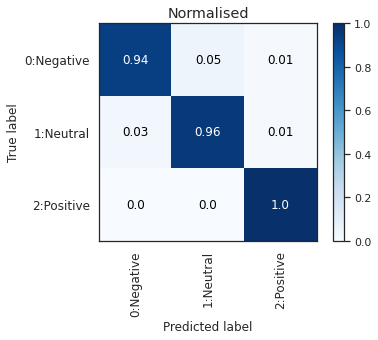

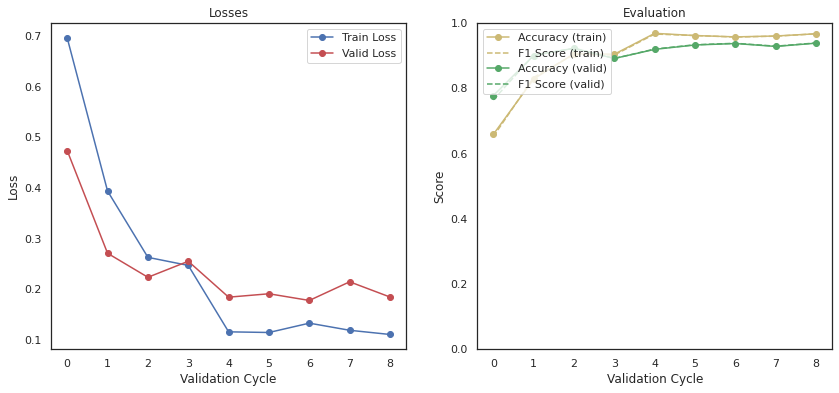

Epoch:  67%|██████▋   | 2/3 [04:22<02:09, 129.72s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.1719, Acc: 0.9498, F1: 0.9504
Epoch: 3/3, Loss: 0.2547, Acc: 0.9297, F1: 0.9307
Epoch: 3/3, Loss: 0.2207, Acc: 0.9375, F1: 0.9385
Epoch: 3/3, Loss: 0.2018, Acc: 0.9364, F1: 0.9372
Epoch: 3/3, Loss: 0.2024, Acc: 0.9353, F1: 0.9362

Epoch: 3, Loss: 0.2024, Acc: 0.9353, F1: 0.9362



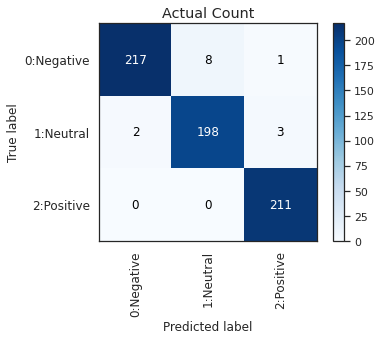

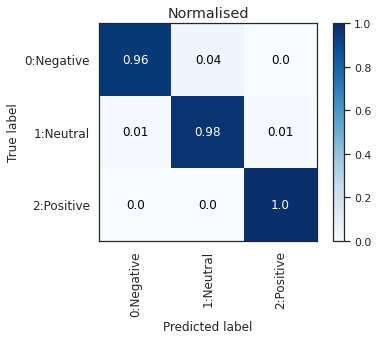

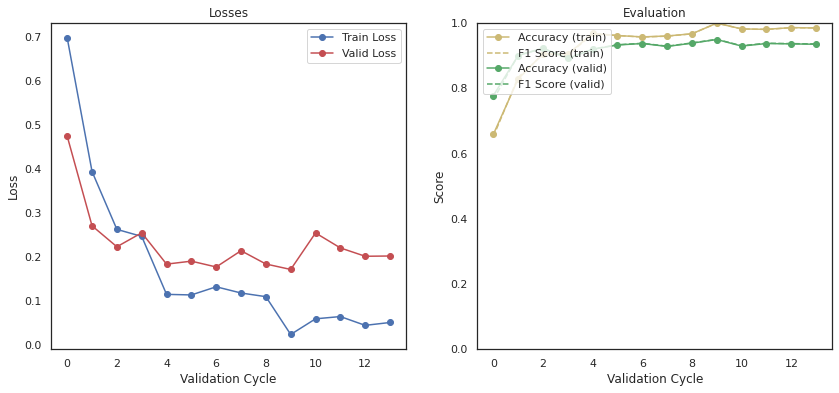

Epoch: 100%|██████████| 3/3 [06:38<00:00, 132.79s/it]


############## cleaning up ###############

############### k-fold: 3 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

class names: ['0:Negative', '1:Neutral', '2:Positive']

===== Total Training Steps: 345 = (115 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.4458, Acc: 0.7924, F1: 0.7845
Epoch: 1/3, Loss: 0.3862, Acc: 0.8527, F1: 0.8501
Epoch: 1/3, Loss: 0.2644, Acc: 0.9085, F1: 0.9097
Epoch: 1/3, Loss: 0.2365, Acc: 0.9018, F1: 0.9023

Epoch: 1, Loss: 0.2365, Acc: 0.9018, F1: 0.9023



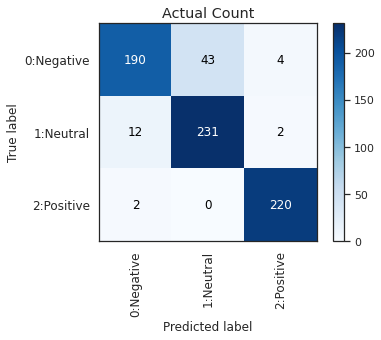

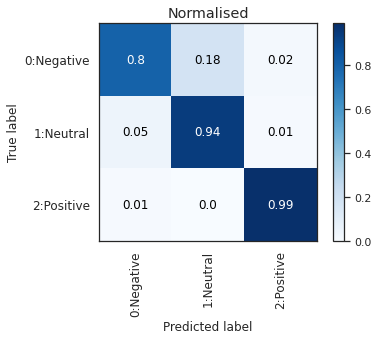

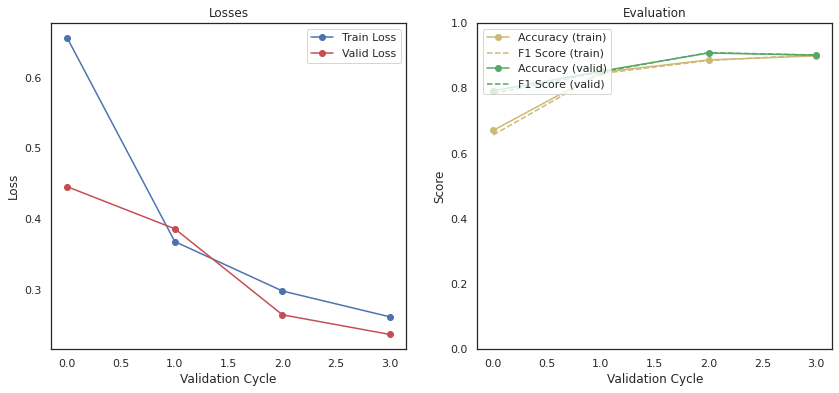

Epoch:  33%|███▎      | 1/3 [02:07<04:14, 127.17s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.2361, Acc: 0.9062, F1: 0.9068
Epoch: 2/3, Loss: 0.2161, Acc: 0.9252, F1: 0.9261
Epoch: 2/3, Loss: 0.2847, Acc: 0.9085, F1: 0.9094
Epoch: 2/3, Loss: 0.2114, Acc: 0.9263, F1: 0.9272
Epoch: 2/3, Loss: 0.2085, Acc: 0.9308, F1: 0.9317

Epoch: 2, Loss: 0.2085, Acc: 0.9308, F1: 0.9317



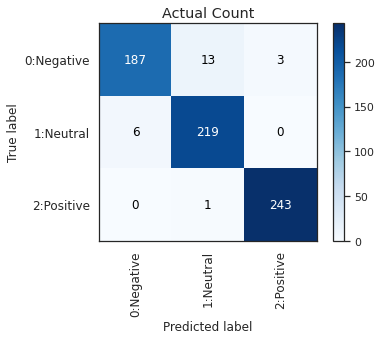

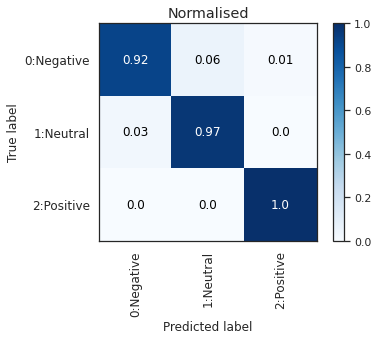

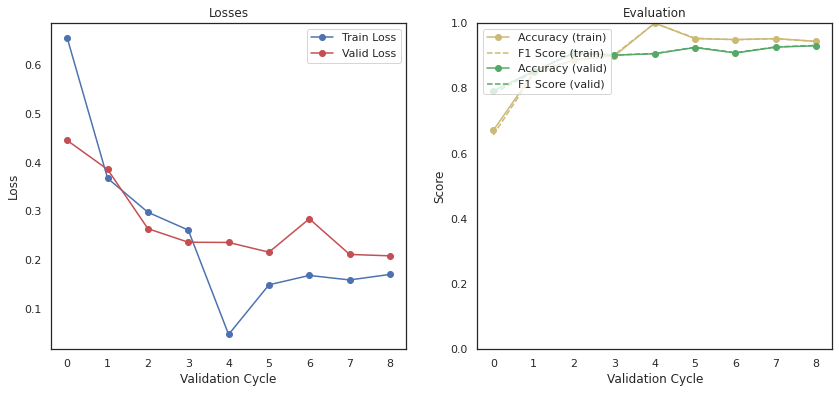

Epoch:  67%|██████▋   | 2/3 [04:22<02:09, 129.65s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.2010, Acc: 0.9297, F1: 0.9304
Epoch: 3/3, Loss: 0.2134, Acc: 0.9364, F1: 0.9373
Epoch: 3/3, Loss: 0.2206, Acc: 0.9353, F1: 0.9362
Epoch: 3/3, Loss: 0.2011, Acc: 0.9353, F1: 0.9362
Epoch: 3/3, Loss: 0.1788, Acc: 0.9408, F1: 0.9417

Epoch: 3, Loss: 0.1788, Acc: 0.9408, F1: 0.9417



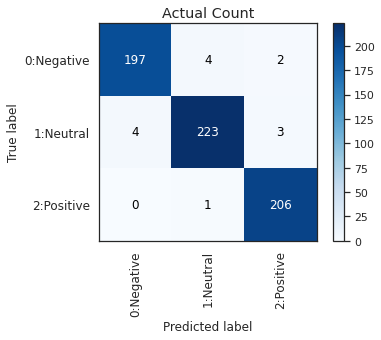

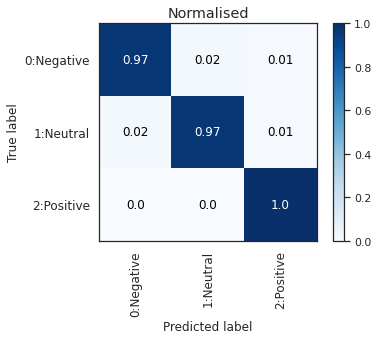

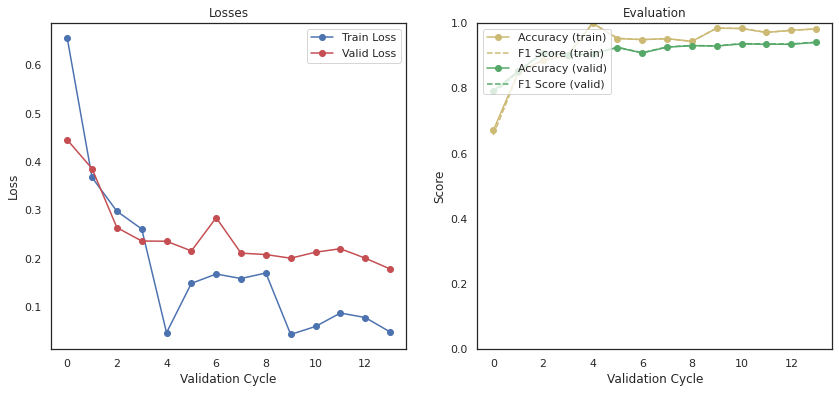

Epoch: 100%|██████████| 3/3 [06:38<00:00, 132.75s/it]


############## cleaning up ###############

############### k-fold: 4 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

class names: ['0:Negative', '1:Neutral', '2:Positive']

===== Total Training Steps: 345 = (115 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.4512, Acc: 0.8158, F1: 0.8153
Epoch: 1/3, Loss: 0.3115, Acc: 0.8828, F1: 0.8831
Epoch: 1/3, Loss: 0.2614, Acc: 0.9074, F1: 0.9072
Epoch: 1/3, Loss: 0.2413, Acc: 0.9085, F1: 0.9088

Epoch: 1, Loss: 0.2413, Acc: 0.9085, F1: 0.9088



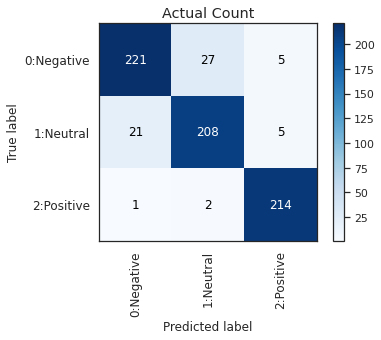

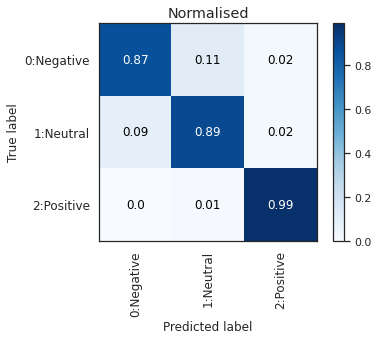

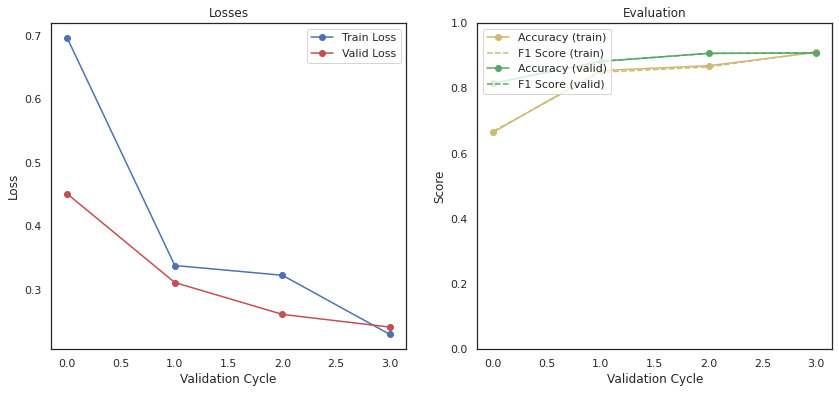

Epoch:  33%|███▎      | 1/3 [02:07<04:14, 127.41s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.2202, Acc: 0.9196, F1: 0.9203
Epoch: 2/3, Loss: 0.2039, Acc: 0.9364, F1: 0.9367
Epoch: 2/3, Loss: 0.2332, Acc: 0.9342, F1: 0.9344
Epoch: 2/3, Loss: 0.2161, Acc: 0.9397, F1: 0.9400
Epoch: 2/3, Loss: 0.1843, Acc: 0.9431, F1: 0.9437

Epoch: 2, Loss: 0.1843, Acc: 0.9431, F1: 0.9437



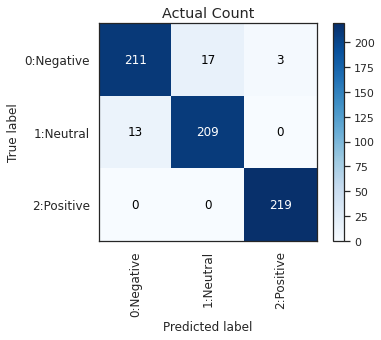

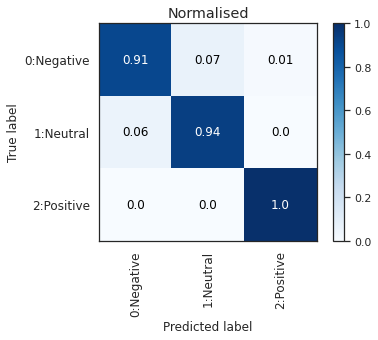

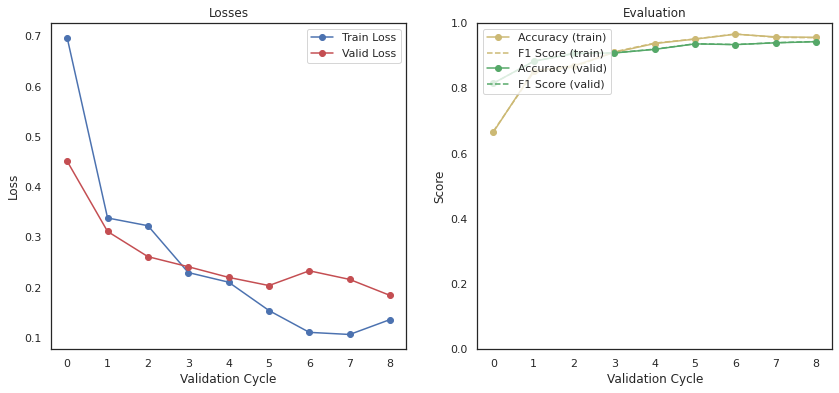

Epoch:  67%|██████▋   | 2/3 [04:23<02:09, 129.87s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.1762, Acc: 0.9375, F1: 0.9381
Epoch: 3/3, Loss: 0.2283, Acc: 0.9275, F1: 0.9278
Epoch: 3/3, Loss: 0.2060, Acc: 0.9453, F1: 0.9458
Epoch: 3/3, Loss: 0.1827, Acc: 0.9397, F1: 0.9404
Epoch: 3/3, Loss: 0.1937, Acc: 0.9431, F1: 0.9438

Epoch: 3, Loss: 0.1937, Acc: 0.9431, F1: 0.9438



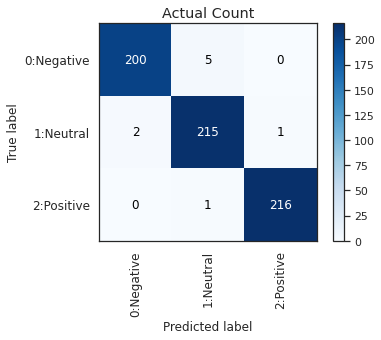

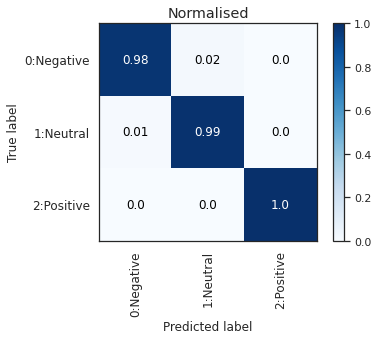

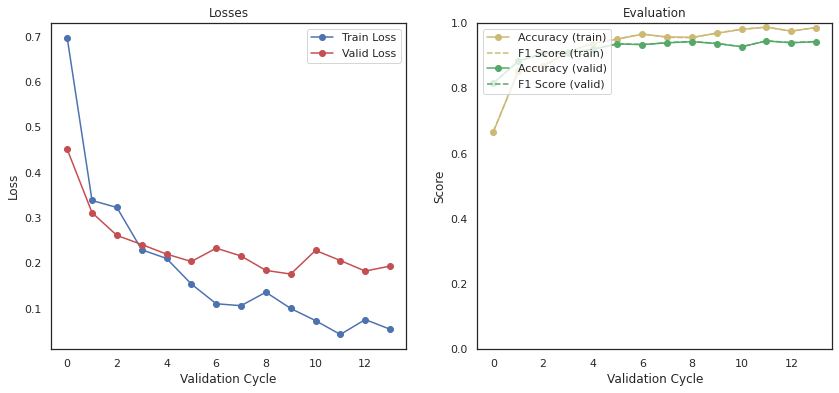

Epoch: 100%|██████████| 3/3 [06:38<00:00, 132.85s/it]


############## cleaning up ###############

############### k-fold: 5 ###############


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

class names: ['0:Negative', '1:Neutral', '2:Positive']

===== Total Training Steps: 345 = (115 batches x 3 epochs) =====

===== Epoch: 1 =====
Epoch: 1/3, Loss: 0.5005, Acc: 0.7935, F1: 0.7951
Epoch: 1/3, Loss: 0.2822, Acc: 0.9029, F1: 0.9036
Epoch: 1/3, Loss: 0.2661, Acc: 0.8951, F1: 0.8959
Epoch: 1/3, Loss: 0.2611, Acc: 0.9152, F1: 0.9158

Epoch: 1, Loss: 0.2611, Acc: 0.9152, F1: 0.9158



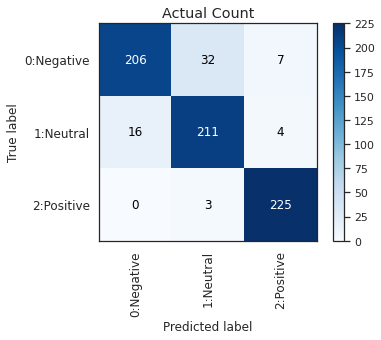

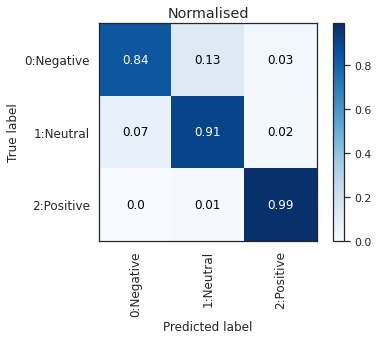

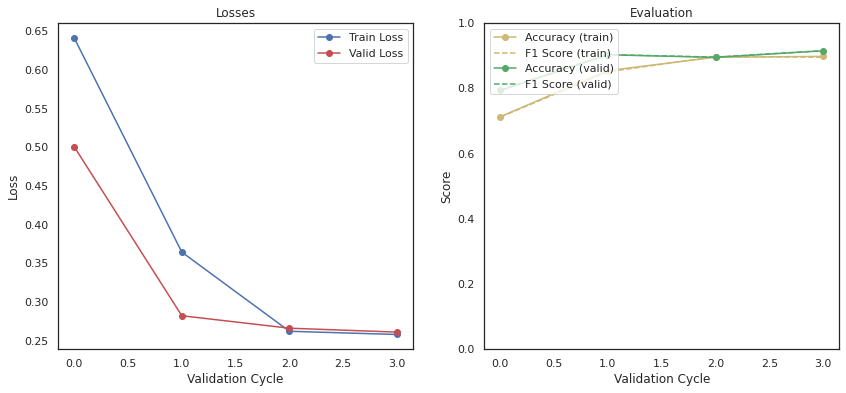

Epoch:  33%|███▎      | 1/3 [02:07<04:14, 127.46s/it]


===== Epoch: 2 =====
Epoch: 2/3, Loss: 0.2178, Acc: 0.9263, F1: 0.9268
Epoch: 2/3, Loss: 0.2364, Acc: 0.9330, F1: 0.9336
Epoch: 2/3, Loss: 0.2699, Acc: 0.9241, F1: 0.9247
Epoch: 2/3, Loss: 0.2402, Acc: 0.9275, F1: 0.9278
Epoch: 2/3, Loss: 0.2147, Acc: 0.9208, F1: 0.9216

Epoch: 2, Loss: 0.2147, Acc: 0.9208, F1: 0.9216



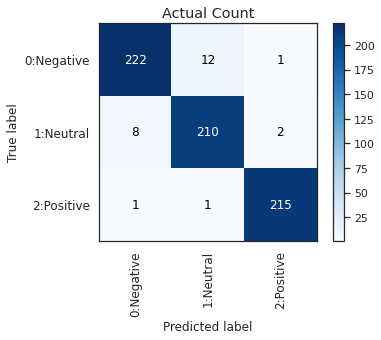

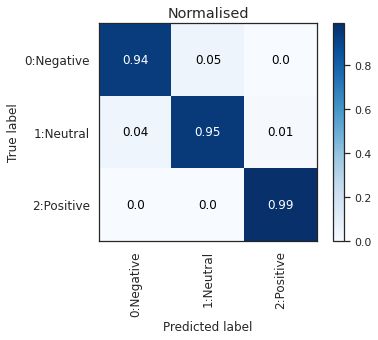

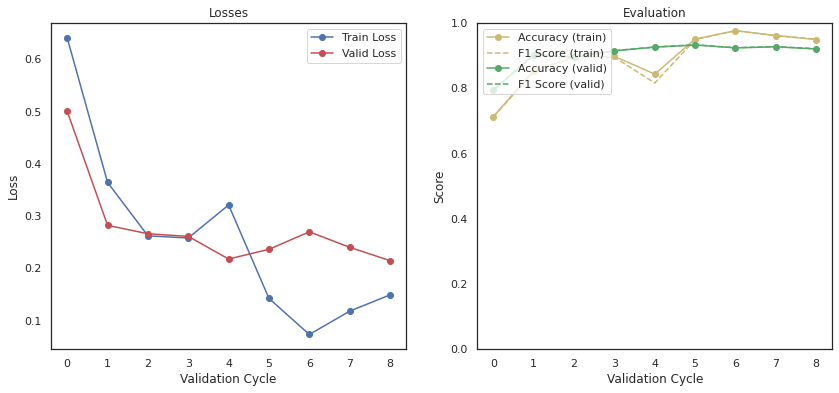

Epoch:  67%|██████▋   | 2/3 [04:23<02:09, 129.94s/it]


===== Epoch: 3 =====
Epoch: 3/3, Loss: 0.2117, Acc: 0.9297, F1: 0.9304
Epoch: 3/3, Loss: 0.2423, Acc: 0.9364, F1: 0.9370
Epoch: 3/3, Loss: 0.2436, Acc: 0.9330, F1: 0.9337
Epoch: 3/3, Loss: 0.2337, Acc: 0.9330, F1: 0.9338
Epoch: 3/3, Loss: 0.2405, Acc: 0.9364, F1: 0.9370

Epoch: 3, Loss: 0.2405, Acc: 0.9364, F1: 0.9370



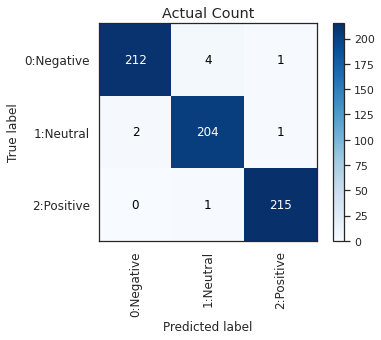

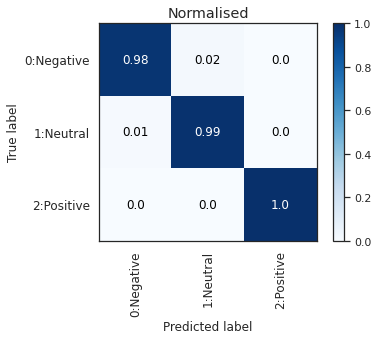

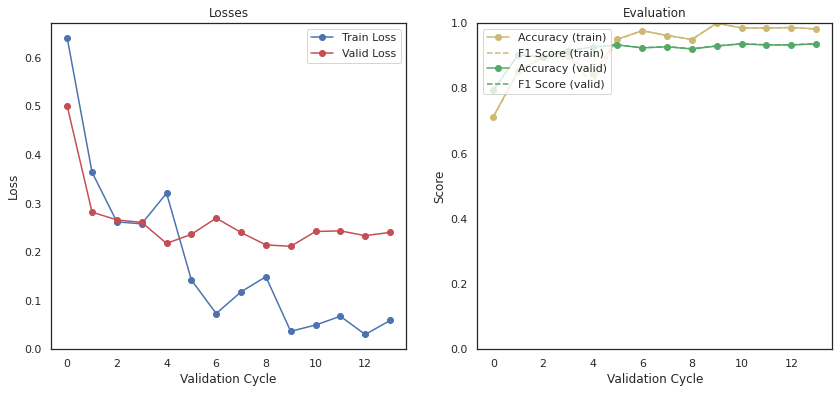

Epoch: 100%|██████████| 3/3 [06:38<00:00, 132.96s/it]


############## cleaning up ###############
Process Time (sec): 2008.7779915320002
acc: 0.9364, f1: 0.9370, duration: 2.0087779915320003
CPU times: user 19min 55s, sys: 13min 20s, total: 33min 15s
Wall time: 33min 28s


In [ ]:
%%time
loss_folds, acc_folds, f1_folds, model_final = train(NUM_FOLDS,
                                                     MODEL_PATH, 
                                                     NUM_LABELS, 
                                                     train_df['text_raw'], 
                                                     train_df['labels'], 
                                                     EPOCHS, 
                                                     PATIENCE, 
                                                     BATCH_SIZE, 
                                                     SEQ_LEN, 
                                                     LR)

In [ ]:
results = pd.DataFrame({ "loss": loss_folds, "acc": acc_folds, "f1": f1_folds })
results

,loss,acc,f1
0,0.148240,0.953125,0.953686
1,0.202392,0.935268,0.936205
2,0.178797,0.940848,0.941659
3,0.193728,0.943080,0.943757
4,0.240472,0.936384,0.936956


In [ ]:
results.mean()

loss    0.192726
acc     0.941741
f1      0.942452
dtype: float64

In [ ]:
results.to_csv(RESULTS_PATH)

# Infer

In [ ]:
BATCH_SIZE = 32
SEQ_LEN = 180
UNIQUE_LABELS = ["negative", "neutral", "positive"]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(UNIQUE_LABELS))
#model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu'))) # When CPU mode
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
# neutral, negative, positive
texts = ["Hello the article is now cheaper than I ordered it at that time, so I have the favorable price paid. Is that okay or ok from your side?",
         "How long do I have to wait for my ordered goods ... that&#39;s not very customer friendly ..",
         "Delivery relatively fast, the ordered items fit the size and are very nice"]

In [ ]:
def get_input_ids_list(tokenizer, texts):
    input_ids_list = []
    for text in texts:
        input_ids = tokenizer.encode(text)
        input_ids.extend([0] * SEQ_LEN)
        input_ids = input_ids[:SEQ_LEN]
        input_ids_list.append(input_ids)

    return input_ids_list

In [ ]:
input_ids_list = get_input_ids_list(tokenizer, texts)
predict_data = TensorDataset(torch.tensor(input_ids_list))
predict_sampler = SequentialSampler(predict_data) 
predict_dataloader = DataLoader(predict_data, sampler=predict_sampler, batch_size=BATCH_SIZE)

In [ ]:
predictions_list = []
model.eval()
for batch in predict_dataloader:
    input_ids_batch = batch[0].to(device)
    with torch.no_grad():
        output = model(input_ids_batch)
    predictions_list.extend(np.argmax(F.softmax(output[0], dim=1).cpu().detach().numpy(), axis=1))

In [ ]:
predictions_list

[1, 0, 2]

In [ ]:
predicted_sentiments = [UNIQUE_LABELS[pred] for pred in predictions_list]

In [ ]:
predicted_sentiments

['neutral', 'negative', 'positive']

In [ ]:
df_out = pd.DataFrame({ "p_sentiment":  predicted_sentiments})
df_out.head()

,p_sentiment
0,neutral
1,negative
2,positive
